### 导入项目需要的各种库
本项目使用随机森林算法

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read Kaggle datasets
X_train = pd.read_csv('./Data/career-con-2019/X_train.csv')
y_train = pd.read_csv('./Data/career-con-2019/y_train.csv')

In [3]:
# 看下训练集里的数据是什么样子的，有487680个样本，每个样本13个特征，是一个二维矩阵
X_train.ndim, X_train.shape

(2, (487680, 13))

In [4]:
# split X_train
samples = 20
time_series = 128
start_x = X_train.shape[0] - samples*time_series
# 训练集是从第一个样本一直到倒数第21个样本，测试集是最后20个样本
X_train, X_test = X_train.iloc[:start_x], X_train.iloc[start_x:]
# split y_train
start_y = y_train.shape[0] - samples
# 训练集和测试集的lable的选择同样本一样
y_train, y_test = y_train.iloc[:start_y], y_train.iloc[start_y:]

In [5]:
# 这个是 pandas 库的函数，可以输出读入表格的一些具体信息，这对于加快数据预处理非常有帮助
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485120 entries, 0 to 485119
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 485120 non-null  object 
 1   series_id              485120 non-null  int64  
 2   measurement_number     485120 non-null  int64  
 3   orientation_X          485120 non-null  float64
 4   orientation_Y          485120 non-null  float64
 5   orientation_Z          485120 non-null  float64
 6   orientation_W          485120 non-null  float64
 7   angular_velocity_X     485120 non-null  float64
 8   angular_velocity_Y     485120 non-null  float64
 9   angular_velocity_Z     485120 non-null  float64
 10  linear_acceleration_X  485120 non-null  float64
 11  linear_acceleration_Y  485120 non-null  float64
 12  linear_acceleration_Z  485120 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.1+ MB


In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(485120, 13) (3790, 3) (2560, 13) (20, 3)


In [8]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [12]:
# 把第一列 row_id 去掉(现在还不知道为啥)
X_train = X_train.drop(['row_id', 'measurement_number'], axis=1)
X_test = X_test.drop(['row_id', 'measurement_number'], axis=1)

In [13]:
X_train.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [14]:
X_test.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
485120,3790,0.70992,0.68801,0.10876,0.10405,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040
485121,3790,0.70968,0.68818,0.10901,0.10429,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030
485122,3790,0.70967,0.68836,0.10872,0.10348,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370
485123,3790,0.70975,0.68843,0.10819,0.10303,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024
485124,3790,0.70968,0.68858,0.10784,0.10289,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140


In [15]:
y_train.keys()

Index(['series_id', 'group_id', 'surface'], dtype='object')

In [16]:
y_train = y_train.drop('group_id', axis=1)
y_test = y_test.drop('group_id', axis=1)

In [17]:
y_train.head()

,series_id,surface
0,0,fine_concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,soft_tiles


In [18]:
y_test.head()

,series_id,surface
3790,3790,hard_tiles_large_space
3791,3791,concrete
3792,3792,soft_pvc
3793,3793,tiled
3794,3794,hard_tiles_large_space


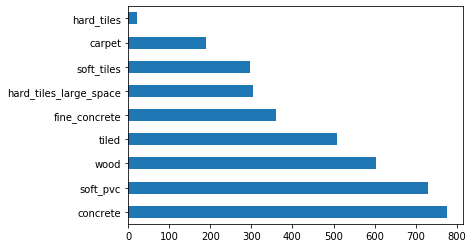

In [21]:
# Classes are not balanced, each class has different count
# 看一下每种类型的地面各测试了多少组
y_train['surface'].value_counts().plot(kind='barh')

In [22]:
# Feature Engineering, we have multiple series_id corresponding to different measurements. We will take single measurement for
# corresponding series_id. This single measurement will be chosen as max, min, abs, std, mean etc.

columns = ['orientation', 'angular_velocity', 'linear_acceleration']
for i in columns:
    if(i == 'orientation'):
        X_train[i] = X_train[i+'_X'] + X_train[i+'_Y'] + X_train[i+'_Z'] + X_train[i+'_W']
        X_test[i] = X_test[i+'_X'] + X_test[i+'_Y'] + X_test[i+'_Z'] + X_test[i+'_W']
    else:
        X_train[i] = X_train[i+'_X'] + X_train[i+'_Y'] + X_train[i+'_Z']
        X_test[i] = X_test[i+'_X'] + X_test[i+'_Y'] + X_test[i+'_Z']

In [23]:
X_train.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,orientation,angular_velocity,linear_acceleration
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,-1.60373,0.125978,-8.39877
1,0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,-1.60377,0.101175,-7.56645
2,0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,-1.60377,0.030230,-7.39879
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,-1.60380,-0.002579,-8.56986
4,0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,-1.60378,0.018032,-9.48179


In [24]:
X_test.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,orientation,angular_velocity,linear_acceleration
485120,3790,0.70992,0.68801,0.10876,0.10405,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040,1.61074,-0.699458,-23.95209
485121,3790,0.70968,0.68818,0.10901,0.10429,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030,1.61116,-0.459741,-39.00490
485122,3790,0.70967,0.68836,0.10872,0.10348,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370,1.61023,0.870862,-20.48321
485123,3790,0.70975,0.68843,0.10819,0.10303,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024,1.60940,0.940830,-4.02260
485124,3790,0.70968,0.68858,0.10784,0.10289,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140,1.60899,0.041380,36.10070


In [28]:
T_train = pd.DataFrame()
T_test = pd.DataFrame()

In [29]:
%%time
# Making columns for max, min, mean, median, abs_max, std, quartile(25%), quartile(50%), quartile(75%)
# This will take some time, be patient :)
# 拿出训练集的每一列（每一列是一个对象）
# 第一列是 series_id, 抛去不看
# 对于每组128个样本，对其每个特征分别计算 max, min, mean, median, abs_max, std, quartile(25%), quartile(50%), quartile(75%)
# 这样就将这组的 128 个样本合并成了一个样本
# 原来每个样本有 13 个特征，每个特征通过计算合并生成 9 个值，这样就总共有 9 * 13 = 127 个特征了
# 再加上一个对应的 lable，共 128 列
# 合并之后就只有 485120 / 128 = 3790 个样本了
for i in X_train.columns[1:]:
    T_train[i+'_max'] = X_train.groupby(by='series_id')[i].max()
    T_test[i+'_max'] = X_test.groupby(by='series_id')[i].max()

    T_train[i+'_min'] = X_train.groupby(by='series_id')[i].min()
    T_test[i+'_min'] = X_test.groupby(by='series_id')[i].min()

    T_train[i+'_mean'] = X_train.groupby(by='series_id')[i].mean()
    T_test[i+'_mean'] = X_test.groupby(by='series_id')[i].mean()

    T_train[i+'_median'] = X_train.groupby(by='series_id')[i].median()
    T_test[i+'_median'] = X_test.groupby(by='series_id')[i].median()

    T_train[i+'_quantile_25'] = X_train.groupby(by='series_id')[i].quantile(0.25)
    T_test[i+'_quantile_25'] = X_test.groupby(by='series_id')[i].quantile(0.25)

    T_train[i+'_quantile_50'] = X_train.groupby(by='series_id')[i].quantile(0.5)
    T_test[i+'_quantile_50'] = X_test.groupby(by='series_id')[i].quantile(0.5)

    T_train[i+'_quantile_75'] = X_train.groupby(by='series_id')[i].quantile(0.75)
    T_test[i+'_quantile_75'] = X_test.groupby(by='series_id')[i].quantile(0.75)

    T_train[i+'_abs_max'] = X_train.groupby(by='series_id')[i].apply(lambda x: np.max(np.abs(x)))
    T_test[i+'_abs_max'] = X_test.groupby(by='series_id')[i].apply(lambda x: np.max(np.abs(x)))

    T_train[i+'_std'] = X_train.groupby(by='series_id')[i].std()
    T_test[i+'_std'] = X_test.groupby(by='series_id')[i].std()

CPU times: user 18.1 s, sys: 279 ms, total: 18.4 s
Wall time: 18.3 s


In [30]:
T_train.head()

,orientation_X_max,orientation_X_min,orientation_X_mean,orientation_X_median,orientation_X_quantile_25,orientation_X_quantile_50,orientation_X_quantile_75,orientation_X_abs_max,orientation_X_std,orientation_Y_max,...,angular_velocity_std,linear_acceleration_max,linear_acceleration_min,linear_acceleration_mean,linear_acceleration_median,linear_acceleration_quantile_25,linear_acceleration_quantile_50,linear_acceleration_quantile_75,linear_acceleration_abs_max,linear_acceleration_std
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.75822,-0.75953,-0.758666,-0.758530,-0.758927,-0.758530,-0.758367,0.75953,0.000363,-0.63306,...,0.054317,-1.28960,-12.35360,-6.072777,-5.908943,-7.654925,-5.908943,-4.575425,12.35360,2.435261
1,-0.95837,-0.95896,-0.958606,-0.958595,-0.958720,-0.958595,-0.958480,0.95896,0.000151,0.24270,...,0.114295,5.53280,-18.65331,-6.498839,-6.629450,-8.726562,-6.629450,-4.042725,18.65331,3.483174
2,-0.50944,-0.51434,-0.512057,-0.512035,-0.513110,-0.512035,-0.510947,0.51434,0.001377,-0.84490,...,0.070696,-0.07600,-13.18580,-6.359327,-6.265565,-8.452710,-6.265565,-4.308499,13.18580,2.669858
3,-0.93884,-0.93968,-0.939169,-0.939170,-0.939340,-0.939170,-0.938960,0.93968,0.000227,0.31147,...,0.181952,10.01550,-28.17420,-6.591451,-5.599050,-11.117950,-5.599050,-2.397842,28.17420,6.595729
4,-0.88673,-0.89689,-0.891301,-0.890940,-0.893795,-0.890940,-0.888750,0.89689,0.002955,0.43740,...,0.056376,-3.02387,-10.33257,-6.454662,-6.402965,-7.342180,-6.402965,-5.399779,10.33257,1.541455


In [32]:
T_train.shape

(3790, 117)

In [33]:
T_test.head()

,orientation_X_max,orientation_X_min,orientation_X_mean,orientation_X_median,orientation_X_quantile_25,orientation_X_quantile_50,orientation_X_quantile_75,orientation_X_abs_max,orientation_X_std,orientation_Y_max,...,angular_velocity_std,linear_acceleration_max,linear_acceleration_min,linear_acceleration_mean,linear_acceleration_median,linear_acceleration_quantile_25,linear_acceleration_quantile_50,linear_acceleration_quantile_75,linear_acceleration_abs_max,linear_acceleration_std
series_id,,,,,,,,,,,,,,,,,,,,,
3790,0.71142,0.70935,0.710416,0.710435,0.70993,0.710435,0.710742,0.71142,0.000525,0.68865,...,0.404159,36.158500,-40.31430,-6.246652,-6.895725,-13.283697,-6.895725,1.886032,40.31430,13.149371
3791,0.80611,0.80275,0.804211,0.803990,0.80336,0.803990,0.805028,0.80611,0.000996,-0.57208,...,0.639969,122.698700,-183.98310,-7.050724,-5.720045,-13.238715,-5.720045,2.689390,183.98310,37.049539
3792,0.64262,0.63847,0.640428,0.640285,0.63950,0.640285,0.641355,0.64262,0.001154,-0.75698,...,0.066531,-3.546030,-13.45418,-7.449282,-7.228063,-8.577733,-7.228063,-5.831233,13.45418,2.004796
3793,-0.97569,-0.97818,-0.977197,-0.977295,-0.97790,-0.977295,-0.976620,0.97818,0.000703,0.15962,...,0.092794,1.438900,-14.83776,-7.028699,-7.347085,-8.777696,-7.347085,-5.543305,14.83776,2.893449
3794,0.77466,0.75541,0.765214,0.765540,0.76052,0.765540,0.769912,0.77466,0.005612,0.63844,...,0.187165,8.445411,-26.26670,-6.552662,-6.358669,-10.259453,-6.358669,-1.980195,26.26670,6.625069


In [34]:
T_test.shape

(20, 117)

In [36]:
X_train = T_train
X_test = T_test

In [40]:
%%time
rfc = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5)
rfc.fit(X_train, y_train['surface'])

CPU times: user 2.73 s, sys: 11.7 ms, total: 2.75 s
Wall time: 2.75 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
%%time
accuracies = cross_val_score(rfc, X_train, y_train['surface'], cv = 10)

CPU times: user 24 s, sys: 111 ms, total: 24.1 s
Wall time: 24.2 s


In [42]:
print(accuracies)
print(accuracies.mean())
print(accuracies.std())

[0.82849604 0.87862797 0.81794195 0.88390501 0.89182058 0.87862797
 0.8707124  0.87335092 0.88654354 0.86543536]
0.8675461741424803
0.023445762418493988


In [43]:
rfc.score(X_test, y_test['surface'])

0.85

In [ ]:
# Predictions on test set
y_pred = rfc.predict(test_data)

In [ ]:
df = pd.DataFrame(data=y_pred, index=test_data.index, columns=['surface'])

In [ ]:
df.head()

In [ ]:
df.to_csv('submission.csv')